In [1]:
import os
import sys

import findspark
findspark.init()

from pyspark import SparkContext

sc = SparkContext(master="local[4]")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

In [3]:
combineddata = pd.read_csv("C:/Data-Attraper le flamand rose/combined-data.csv")

In [4]:
from sklearn.preprocessing import LabelEncoder
## Créer un objet encodeur de label 
encoder = LabelEncoder()
## Adapter l'encodeur à la colonne avec la méthode fit de LabelEncoder 
label_encoder = encoder.fit(combineddata['platformType'])
print ("Données catégorielles:", label_encoder.classes_)
donnees_numerique = label_encoder.transform(label_encoder.classes_)
print ("Données numériques:", donnees_numerique)
## Appliquer le codeur adapté à la colonne 
c = label_encoder.transform(combineddata['platformType'])
combineddata['EncoderPlatformType'] = c


Données catégorielles: ['android' 'iphone' 'linux' 'mac' 'windows']
Données numériques: [0 1 2 3 4]


In [5]:
##Remplacer NaN par zéro et l'infini par les nombres définis par l'utilisateur à l'aide des mots-clés nan, posinf et/ou neginf.
combineddata.replace("", np.nan, inplace=True)
##Teste l'élément pour savoir s'il est fini ou non
combineddata = combineddata[np.isfinite(combineddata['count_buyId'])]
##Retour des éléments choisis parmi Dépensier ou Econome selon l'état.
combineddata['user_category'] = np.where(combineddata['avg_price']> 5, 'Depensier', 'Econome')
##Retourne les 5 premières lignes (par défaut).
combineddata.head()

,userId,userSessionId,teamLevel,platformType,count_gameclicks,count_hits,count_buyId,avg_price,EncoderPlatformType,user_category
4,937,5652,1,android,39,0,1.0,1.0,0,Econome
11,1623,5659,1,iphone,129,9,1.0,10.0,1,Depensier
13,83,5661,1,android,102,14,1.0,5.0,0,Econome
17,121,5665,1,android,39,4,1.0,3.0,0,Econome
18,462,5666,1,android,90,10,1.0,3.0,0,Econome


In [6]:
from sklearn import tree ##Importe arbre de décision 
from sklearn.metrics import accuracy_score ##Bibliothèque afin de calculer la précision du modèle 
classifier = tree.DecisionTreeClassifier()
X = combineddata[['teamLevel' ,'count_gameclicks' , 'count_hits','count_buyId' , 'EncoderPlatformType']][0:846]
Y = combineddata['user_category'][0:846]
classifier = classifier.fit(X , Y)
##Test 
X_test = combineddata[['teamLevel' ,'count_gameclicks' , 'count_hits','count_buyId' , 'EncoderPlatformType']][846:1411]
Y_test = combineddata['user_category'][846:1411]
Y_prediction  = classifier.predict(X_test)
print("La précision du modèle : ",accuracy_score(Y_test,Y_prediction))

La précision du modèle :  0.7752212389380531


In [7]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

In [8]:
Y_prediction  = classifier.predict(X_test)
np.unique(Y_prediction)
combineddata_eval = combineddata[846:1411]
combineddata_eval['P_UserCategory'] = Y_prediction
combineddata_eval[['P_UserCategory' , 'user_category']] 
##y true
y_t = combineddata_eval['user_category'] 
##y prediction 
y_p = combineddata_eval['P_UserCategory']

c:\users\you\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
import numpy as np
unique_label = np.unique(y_t)
print(pd.DataFrame(confusion_matrix(y_t, y_p, labels=unique_label), 
                   index=['true:{:}'.format(x) for x in unique_label], 
                   columns=['pred:{:}'.format(x) for x in unique_label]))

                pred:Depensier  pred:Econome
true:Depensier             181            61
true:Econome                66           257


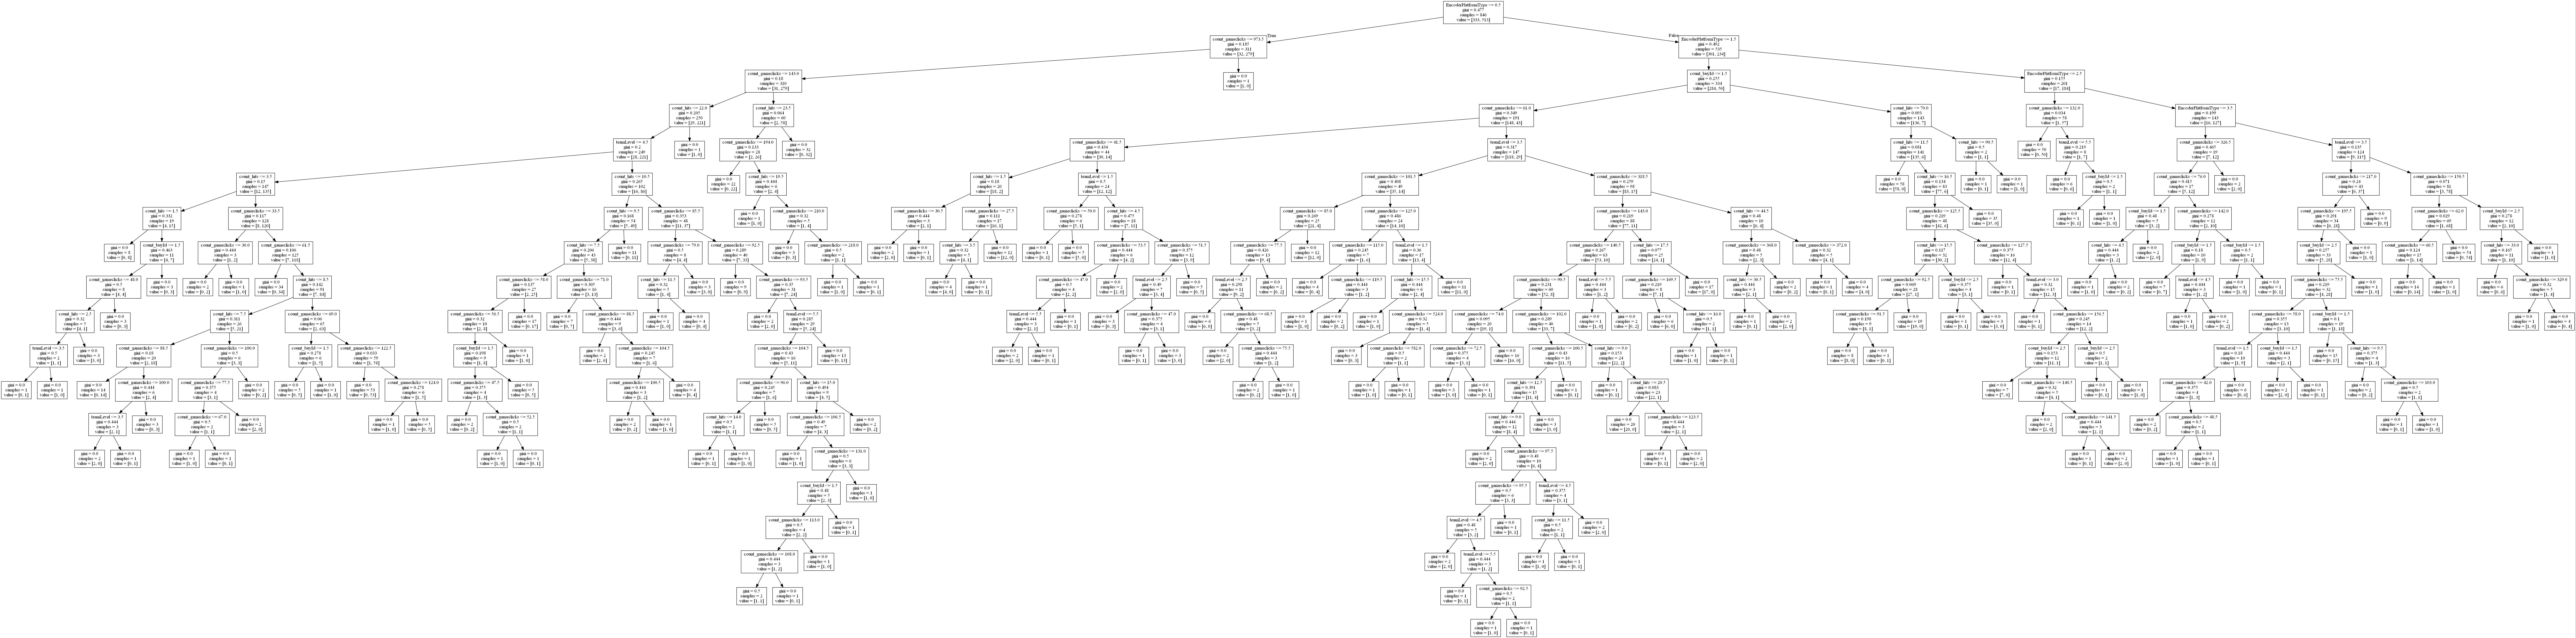

In [11]:
import pydotplus as pdot
from sklearn.tree import export_graphviz, export
##génère représentation GraphViz de l'arbre de décision
export_graphviz(classifier,out_file = "combineddata_tree.odt",feature_names = X.columns )
arbre_graphe = pdot.graphviz.graph_from_dot_file('combineddata_tree.odt')
##créer un jpg
arbre_graphe.write_jpg('combineddata_tree.jpg')
##affichage 
from IPython.display import Image
Image(filename='combineddata_tree.jpg')